# Expectation 
We'll divide the notebook into two parts.

1- we'll get the images from Sentinel-2.

2- then we'll explore the data and create vegetation masks.

# Part One: Fetching data from Sentinel-2 Using Google Earth Engine

The following notebook uses the shapefile provided here: https://drive.google.com/drive/folders/1dU1tV1Aj4QZJIVzWo7wbIdSJi89mMNZ1

to get SENTINEL 2 images from Google earth engine.

Note: Make sure to register in Google earth engine if you want to execute the follwoing code. It is free!



In [1]:
# Install dependencies 
import subprocess

try: 
  import geopandas as gpd
  import numpy as np
  import folium
  import rasterio
  import geemap
except ImportError:
    print('package(s) not installed. Installing ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'rasterio'])
    subprocess.check_call(["python", '-m', 'pip', 'install', 'geopandas'])
    subprocess.check_call(["python", '-m', 'pip', 'install', 'folium'])
    subprocess.check_call(["python", '-m', 'pip', 'install', "geemap"])

package(s) not installed. Installing ...


In [2]:
import geopandas as gpd
import numpy as np
import folium
import rasterio
import geemap
from functools import reduce
from rasterio.plot import show
from rasterio.plot import show_hist
import matplotlib.pyplot as plt
%matplotlib inline

# Checks whether this notebook is running on Google Colab
try:
    import google.colab
    import geemap.eefolium as emap
except:
    import geemap as emap

# Authenticates and initializes Earth Engine
import ee

try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=yixGRK4rkF9eQ19UzhyUKnkBhirFzaPmN259_ook2CI&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AY0e-g63204S__vcT9cug7MLR4V-LsivdVtJi3O4sgmuhRGh7ypE2c2Lodo

Successfully saved authorization token.


In [3]:
# I already imported the the shapefile with the bounding box of aoi to the Earth engine assetes
Regions = ee.FeatureCollection('users/rashagh22/Tharaka_AOI')
S2 = ee.ImageCollection("COPERNICUS/S2")
images = ee.ImageCollection(S2).filterBounds(Regions)\
.filterDate('2019-02-01', '2020-11-08').filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 1)

In [4]:
#The region diplayed below will be exported
# later we'll extract the small region of interest from it
Map = emap.Map(center=[40,-100], zoom=4)
Map.add_basemap('ROADMAP') # Add Google Map
vis_params = {'bands':['B4', 'B3', 'B2'], 'max':1351.045036760246, min:495.2109567383318}
#Display the view to the center of the screen and scale the view
Map.centerObject(Regions, 15)
Map.addLayer(images.median().clip(Regions), vis_params, 'thakara_region')
Map.addLayerControl()
Map

Before exporting the image we are going to calculate the NDVI, later add it as an extra band, and export the image to Google drive.
The NDVI values ranges between (-1 and 1):
non-vegetation (-1 to 0.199), low vegetation
(0.2 to 0.5) and high vegetation (0.501 to 1.0).

In [5]:
# define a function to preprocess the image
def preprocessImage(imageCollection):
  '''
  takes an imageCollection sxtracted from EE and add extra bands to our selected image
  Parameters:
  imageCollection (ee.ImagCollection) : Image collection from EE
  threshold (float) : threshold to extract the ndi masks
    
  Return:
  image (ee.Image) : preprocessed image
  '''
  image = imageCollection.median()
  ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI').toDouble()
  ndmi = image.normalizedDifference(['B8A', 'B11']).rename('NDMI').toDouble()
  ndwi = image.normalizedDifference(['B3', 'B8']).rename('NDWI').toDouble()
  image = reduce(lambda i, b: i.addBands(b), [image, ndvi, ndmi, ndwi])
  return image


In [6]:
# Define the exportation job on GEE server for the preprocessed images
def exportImages(task_config, image, description):
    '''
    Takes task configuration and export images to google drive
    Parameters:
    task_config (Dictionary): the task configuration (folder (string), 
    fileNamePrefix (string), scale (int), region (ee.Geometry))
    image (ee.Image): The image to export
    description (string) : short description for the image
    '''
    # Export image to Google Drive
    task = ee.batch.Export.image.toDrive(image, description, **task_config)
    task.start()
    print("Exporting {}".format(description))
    return task

## Export to Google Drive (Execute the following cell only once)

In [39]:
# Now let's create the task that will export the image from GEE to our drive
 # Calculate the masks bands and add them as extra bands
image = preprocessImage(images)
bands = ["B2","B3","B4","B8","B11","B12", "NDVI", "NDMI", "NDWI"]
image = image.select(bands)

description = 'Thakara region'  # set the output image filename
#assetId = "users/rashagh22/Eth_pop_1"
task_config = {
    'folder': 'Thakara_setinel',
    'fileNamePrefix' : 'Thakara_setinel_',
    'region': Regions.geometry(), # Only the area within our aoi
    'scale': 10
    }
# Export image to Google Drive
task = exportImages(task_config, image, description)
    

KeyboardInterrupt: ignored

# Part Two: Examining the Data




In [7]:
# First let's take a look at the image we exported
# Remeber that our data now is on Google drive

thakara_data = rasterio.open('/content/drive/My Drive/Thakara_setinel/Thakara_setinel_.tif')

In [8]:
# How many bands do we have
thakara_data.descriptions


('B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'NDVI', 'NDMI', 'NDWI')

In [9]:
blue, green, red, nir, swir_1, swir_2, ndvi, ndmi, ndwi = thakara_data.read()

In [11]:
# The bands are just numpy arrays
type(ndvi)

numpy.ndarray

In [10]:
# Get the min and max values in each of the bands
for band in [blue, green, red, nir, swir_1, swir_2, ndvi, ndmi, ndwi]:
  print(f'min {band.min()} || max {band.max()}')

min 796.0 || max 1899.0
min 704.0 || max 2045.0
min 547.0 || max 2066.0
min 1307.0 || max 3317.0
min 1666.0 || max 3391.0
min 837.0 || max 2458.0
min 0.11236350827756252 || max 0.6772364011343129
min -0.14216688347890727 || max 0.2378449408672799
min -0.6127912741695587 || max -0.1644535240040858


Check out [this reference](https://www.agricolus.com/en/indici-vegetazione-ndvi-ndmi-istruzioni-luso/) to know more about NDVI and NDMI values and what they are represent. This will help us create the masks fro the data later on

Now let's Visualize all the different bands.

In [12]:
# scale the values for display purposes
def normalize(band):
  """Normalizes numpy arrays into scale 0.0 - 1.0"""
  band_min, band_max = band.min(), band.max()
  return ((band - band_min)/(band_max - band_min))

bluen = normalize(blue)
greenn = normalize(green)
redn = normalize(red)
nirn = normalize(nir)


In [13]:
# Use numpy array to stack two stacks of bands
rgb = np.dstack((redn, greenn, bluen))
nrg = np.dstack((nirn, redn, greenn))

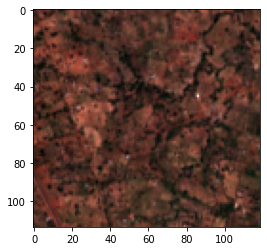

In [60]:
# Checking out the image in real colors
fig = plt.imshow(rgb)

plt.show()

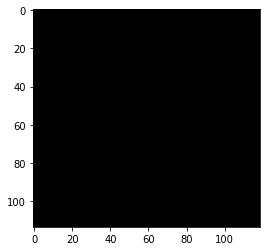

In [75]:
# Checking out our ndvi image diffirent thresholds
fig = plt.imshow(ndvi,cmap= 'gray', vmin=0.7, vmax=0.8)

plt.show()

Now we can use the same previous approach to create different masks for our image and save it as png.

In [59]:
# Create different ndvi masks
def create_mask(ndvi_array, min_value, max_value):
  cmap = plt.cm.gray
  norm = plt.Normalize(vmin= min_value, vmax=max_value)

  # map the normalized data to colors
  # image is now RGBA (512x512x4) 
  mask = cmap(norm(ndvi_array))
  return mask


mid_high_canopy = create_mask(ndvi, 0.5, 1.0)

plt.imsave(f'/content/drive/My Drive/Thakara_vegetation_masks/mid_high_canopy.png', mid_high_canopy, cmap=cmap)